# Off-policy Ensemble

In [2]:
#load infowave data
import pickle, random 
import numpy as np

y_sparse = pickle.load(open('data/all_question_article_ratings.pkl','rb'))
y = np.zeros((996,321))

for i,j in y_sparse:
    y[i,j] = 1
    
# X = pickle.load(open('question_tfidf_bow.pickle','rb'))   
# X = X.todense()

X = np.zeros((996,25))
intent_features = pickle.load(open('data/all_questions_intent.pkl','rb'))   

for k,v in intent_features.items():
    X[k,:] = v



In [3]:
from sklearn.linear_model import LogisticRegression
K_learners = 5

In [4]:
st_seed = 0
end_seed = 300

st_exploration = 0
end_exploration = 800

st_test = 800
end_test = 996

explore_list = random.sample(range(996),end_exploration) 
seed_list = random.sample(explore_list,end_seed)
test_list = np.setdiff1d(range(996), explore_list)

# rearrange the data 

X =np.vstack((X[explore_list,:], X[test_list,:]))
y= np.vstack((y[explore_list,:], y[test_list,:]))

In [5]:
Xseed = X[st_seed:end_seed, :]
Xexplore_sample = X[st_exploration:end_exploration, :]
yexplore_sample = y[st_exploration:end_exploration, :]
Xtest = X[st_test:end_test, :]
ytest = y[st_test:end_test, :]
nchoices = y.shape[1]

actions_ensemble = np.zeros([K_learners, end_exploration-st_exploration], dtype=int)
rewards_ensemble = np.zeros([K_learners, end_exploration-st_exploration])
prob_actions_ensemble = np.zeros([K_learners, end_exploration-st_exploration])


# Xseed=X[seed_list,:]
# Xexplore_sample=X[explore_list,:]
# Xtest=X[test_list,:]
# nchoices=y.shape[1]

# actions_ensemble = np.zeros([K_learners, len(explore_list)], dtype=int)
# rewards_ensemble = np.zeros([K_learners, len(explore_list)])
# prob_actions_ensemble = np.zeros([K_learners, len(explore_list)])


In [6]:
for k in range(K_learners):
    sample_index = np.random.randint(st_seed, end_seed, size=3000)
    Xseed_sample = Xseed[sample_index, :]
    
    explorer = LogisticRegression(solver="lbfgs", max_iter=1500, multi_class='auto')
    explorer.fit(Xseed_sample, np.argmax(y[sample_index], axis=1))
    
    actions_ensemble[k] = explorer.predict(Xexplore_sample)
    rewards_ensemble[k] = y[st_exploration:end_exploration, :]\
                        [np.arange(end_exploration - st_exploration), actions_ensemble[k]]

    ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
    ix_internal_actions = [ix_internal_actions[i] for i in actions_ensemble[k]]

    ix_internal_actions = np.array(ix_internal_actions)
    prob_actions_ensemble[k] = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                               ix_internal_actions]


In [7]:
from contextualbandits.offpolicy import OffsetTree
from sklearn.linear_model import LogisticRegression

In [8]:
reward_ensemble = np.empty([K_learners, ])

In [10]:
for k in range(K_learners):
    new_policy = OffsetTree(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000), nchoices=y.shape[1])
    new_policy.fit(X=Xexplore_sample, a=actions_ensemble[k], r=rewards_ensemble[k], p=prob_actions_ensemble[k])
    mean_reward_ot = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
    reward_ensemble[k] = mean_reward_ot


    

/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home

In [11]:
from collections import Counter

In [12]:
ensemble_predict = np.zeros([K_learners, 996-end_exploration])
vote = np.zeros([end_test-st_test, ], dtype = int)

for k in range(K_learners):
    new_policy = OffsetTree(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=1500), nchoices=y.shape[1])
    new_policy.fit(X=Xexplore_sample, a=actions_ensemble[k], r=rewards_ensemble[k], p=prob_actions_ensemble[k])
    
    ensemble_predict[k] = new_policy.predict(Xtest)
    
for i in range(end_test-st_test):
    
    c = Counter(ensemble_predict[:, i])  
    mode_count = max(c.values())
    mode = [key for key, count in c.items() if count == mode_count]
    

    vote[i] = mode[0]
    
mean_reward_ot_ensemble = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), vote])

print("Test set mean reward - Offset Tree Ensemble technique: ", mean_reward_ot_ensemble)

/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home

Test set mean reward - Offset Tree Ensemble technique:  0.0


In [13]:
from sklearn.metrics import accuracy_score
yt = np.argmax(ytest, axis=1)
yr = np.argmax(yexplore_sample, axis=1)

In [14]:
accuracy_score(yt,vote)

0.0

# Off-policy Methods Comparison

In [15]:
from sklearn.linear_model import LogisticRegression

# separating the covariates data for each case
Xseed = X[st_seed:end_seed, :]
Xexplore_sample = X[st_exploration:end_exploration, :]
Xtest = X[st_test:end_test, :]
nchoices = y.shape[1]

# now constructing an exploration policy as explained above, with fully-labeled data
explorer = LogisticRegression(solver="lbfgs", max_iter=15000, multi_class='auto')
explorer.fit(Xseed, np.argmax(y[st_seed:end_seed], axis=1))

# letting the exploration policy choose actions for the new policy input
actions_explore_sample = explorer.predict(Xexplore_sample)
rewards_explore_sample = y[st_exploration:end_exploration, :]\
                        [np.arange(end_exploration - st_exploration), actions_explore_sample]

# extracting the probabilities it estimated
ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions = [ix_internal_actions[i] for i in actions_explore_sample]
ix_internal_actions = np.array(ix_internal_actions)
prob_actions_explore = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                               ix_internal_actions]

In [16]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior=None, smoothing=None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_naive = np.mean(y[st_test:end_test, :]\
                             [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers: ", mean_reward_naive)
yacc_naive=accuracy_score(new_policy.predict(Xtest), yt)
yacc_naive=accuracy_score(new_policy.predict(Xtest), yt)
yacc_naive_train = accuracy_score(new_policy.predict(Xexplore_sample), yr)
print("Test set accuarcy - Separate Classifiers: ", yacc_naive)
print("Train set accuarcy - Separate Classifiers: ", yacc_naive_train)

Test set mean reward - Separate Classifiers:  0.01020408163265306
Test set accuarcy - Separate Classifiers:  0.01020408163265306
Train set accuarcy - Separate Classifiers:  0.02125


In [17]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior="auto")
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_beta = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Prior: ", mean_reward_beta)
yacc_beta=accuracy_score(new_policy.predict(Xtest), yt)
yacc_beta_train = accuracy_score(new_policy.predict(Xexplore_sample), yr)
print("Test set accuarcy - Separate Classifiers + Prior: ", yacc_beta)
print("Train set accuarcy - Separate Classifiers  + Prior: ", yacc_beta_train)

Test set mean reward - Separate Classifiers + Prior:  0.0
Test set accuarcy - Separate Classifiers + Prior:  0.00510204081632653
Train set accuarcy - Separate Classifiers  + Prior:  0.00375


In [18]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior=None, smoothing = (1,2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_sm = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Smoothing: ", mean_reward_sm)
yacc_sm=accuracy_score(new_policy.predict(Xtest), yt)
yacc_sm_train = accuracy_score(new_policy.predict(Xexplore_sample), yr)
print("Test set accuarcy - Separate Classifiers + Smoothing: ", yacc_sm)
print("Train set accuarcy - Separate Classifiers  + Smoothing: ", yacc_sm_train)

Test set mean reward - Separate Classifiers + Smoothing:  0.0
Test set accuarcy - Separate Classifiers + Smoothing:  0.0
Train set accuarcy - Separate Classifiers  + Smoothing:  0.00125


In [19]:
from contextualbandits.offpolicy import OffsetTree
from sklearn.linear_model import LogisticRegression

new_policy = OffsetTree(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000), nchoices=y.shape[1])
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_ot = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Offset Tree technique: ", mean_reward_ot)
yacc_ot=accuracy_score(new_policy.predict(Xtest), yt)
yacc_ot_train = accuracy_score(new_policy.predict(Xexplore_sample), yr)
print("Test set accuarcy - Offset Tree technique: ", yacc_ot)
print("Train set accuarcy - Offset Tree technique: ", yacc_ot_train)

/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home/syu/anaconda3/lib/python3.6/site-packages/contextualbandits/offpolicy.py:350: RuntimeWarning: invalid value encountered in double_scalars
  w_node = w_node * (w_node.shape[0] / np.sum(w_node))
/home

Test set mean reward - Offset Tree technique:  0.0
Test set accuarcy - Offset Tree technique:  0.0
Train set accuarcy - Offset Tree technique:  0.0


In [20]:
from contextualbandits.offpolicy import DoublyRobustEstimator
from sklearn.linear_model import LogisticRegression, Ridge

new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator: ", mean_reward_dr)
yt = np.argmax(ytest, axis=1)
yacc_dr=accuracy_score(new_policy.predict(Xtest), yt)
yacc_dr_train=accuracy_score(new_policy.predict(Xexplore_sample), yr)
print("Test set accuarcy - Doubly-Robust Estimator: ", yacc_dr)
print("Train set accuarcy - Doubly-Robust Estimator: ", yacc_dr_train)

Test set mean reward - Doubly-Robust Estimator:  0.22448979591836735
Test set accuarcy - Doubly-Robust Estimator:  0.22448979591836735
Train set accuarcy - Doubly-Robust Estimator:  0.25625


In [21]:
new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = "auto", smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_prior = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Prior: ", mean_reward_dr_prior)
yt = np.argmax(ytest, axis=1)
yacc_dr_prior=accuracy_score(new_policy.predict(Xtest), yt)
yacc_dr_prior_train=accuracy_score(new_policy.predict(Xexplore_sample), yr)
print("Test set accuarcy - Doubly-Robust Estimator + Prior: ", yacc_dr_prior)
print("Train set accuarcy - Doubly-Robust Estimator + Prior: ", yacc_dr_prior_train)

Test set mean reward - Doubly-Robust Estimator + Prior:  0.22448979591836735
Test set accuarcy - Doubly-Robust Estimator + Prior:  0.22448979591836735
Train set accuarcy - Doubly-Robust Estimator + Prior:  0.25625


In [22]:
new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = (1, 2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_sm = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Smoothing: ", mean_reward_dr_sm)
yacc_dr_sm=accuracy_score(new_policy.predict(Xtest), yt)
yacc_dr_sm_train=accuracy_score(new_policy.predict(Xexplore_sample), yr)
print("Test set accuarcy - Doubly-Robust Estimator + Smoothing: ", yacc_dr_sm)
print("Train set accuarcy - Doubly-Robust Estimator + Smoothing: ", yacc_dr_sm_train)

Test set mean reward - Doubly-Robust Estimator + Smoothing:  0.22448979591836735
Test set accuarcy - Doubly-Robust Estimator + Smoothing:  0.22448979591836735
Train set accuarcy - Doubly-Robust Estimator + Smoothing:  0.25625


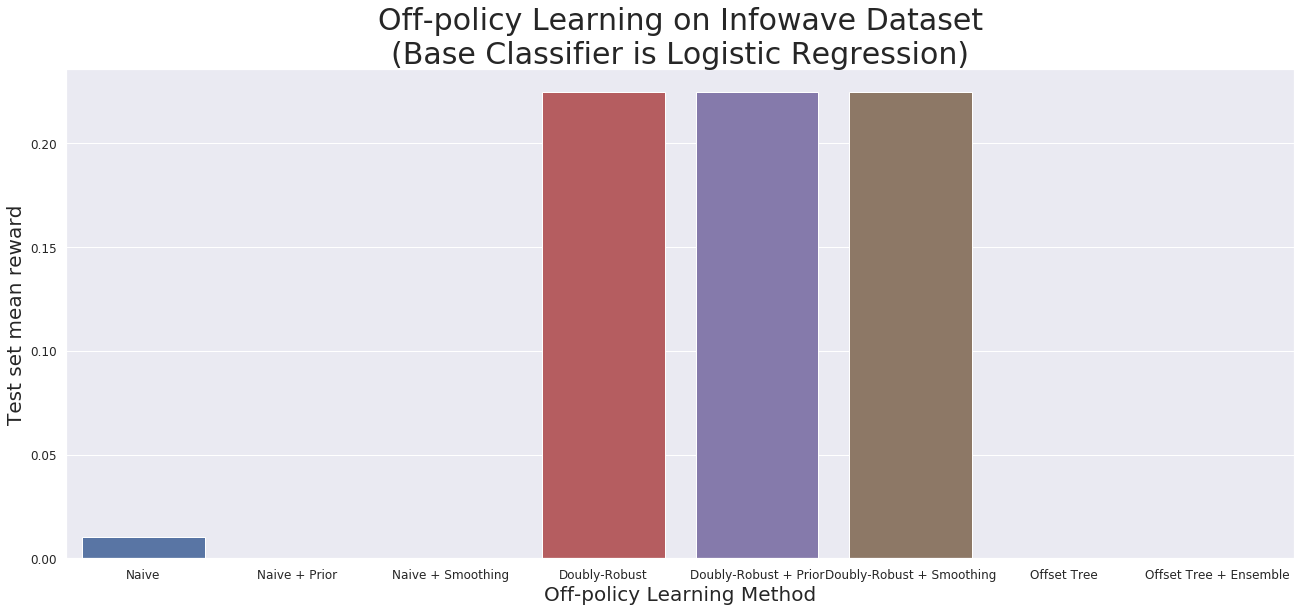

In [24]:
import matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
from pylab import rcParams
%matplotlib inline

results = pd.DataFrame({
    'Off-policy Learning Method' : ['Naive', 'Naive + Prior', 'Naive + Smoothing', 'Doubly-Robust',
                                    'Doubly-Robust + Prior', 'Doubly-Robust + Smoothing', 'Offset Tree', 'Offset Tree + Ensemble'],
    'Test set mean reward' : [mean_reward_naive, mean_reward_beta, mean_reward_sm, mean_reward_dr,
                              mean_reward_dr_prior, mean_reward_dr_sm, mean_reward_ot, mean_reward_ot_ensemble]
})

sns.set(font_scale = 1.1)
rcParams['figure.figsize'] = 22, 9
ax = sns.barplot(x = "Off-policy Learning Method", y="Test set mean reward", data=results)
sns.set(font_scale=2.5)
plt.xlabel("Off-policy Learning Method", fontsize = 20)
plt.ylabel("Test set mean reward", fontsize = 20)
for bar in ax.patches:
    if bar.get_height() > 0.4:
        bar.set_color('teal')
plt.title('Off-policy Learning on Infowave Dataset\n(Base Classifier is Logistic Regression)')
plt.show()

In [203]:
fig = ax.get_figure()
fig.savefig("Off_policy_MAB.png")